# Post processing plots

This notebook used the previously generated data from the [post_process_pointclouds.ipynb](post_process_pointclouds.ipynb) to create some plots.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import history.postprocessing.plotting2 as pplt
import pandas as pd
import numpy as np

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [3]:
CSV_FILE = "/mnt/summer/USERS/DEHECQA/history/output/test_data/postprocess.csv"
PLOT_DIR = "/mnt/summer/USERS/DEHECQA/history/output/test_data/plots"

COREG_DEMS_DIR = os.path.join(PLOT_DIR, "mosaic_coregistered_dems")
RAW_DEMS_DIR = os.path.join(PLOT_DIR, "mosaic_raw_dems")
DDEMS_DIR = os.path.join(PLOT_DIR, "mosaic_ddems")
SLOPES_DIR = os.path.join(PLOT_DIR, "slopes")
HILLSHADE_DIR = os.path.join(PLOT_DIR, "hillshades")
STATS_DIR = os.path.join(PLOT_DIR, "statistics")

global_df = pd.read_csv(CSV_FILE, index_col="code")

## Check the progress of the postprocessing

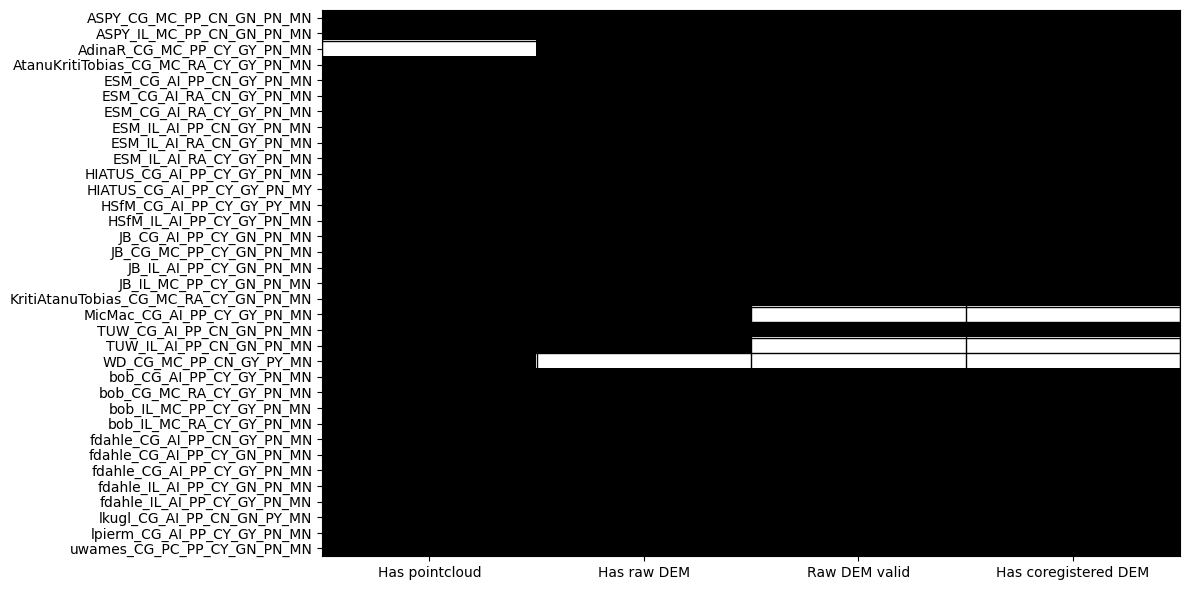

In [4]:
pplt.plot_postprocess_state(global_df)

## Generate raw and coregistered DEMs mosaics

In [5]:
pplt.generate_raw_dems_mosaic(global_df, RAW_DEMS_DIR)
pplt.generate_coregistered_dems_mosaic(global_df, COREG_DEMS_DIR)
pplt.generate_ddems_mosaic(global_df, DDEMS_DIR)

Mosaicing raw DEMs:   9%|███████▉                                                                             | 3/32 [00:00<00:02, 10.00it/s]

mosaicing DDEM-before-coreg:  66%|█████████████████████████████████████████████████▏                         | 21/32 [00:06<00:04,  2.38it/s]/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
mosaicing DDEM-after-coreg:  62%|███████████████████████████████████████████████▌                            | 20/32 [00:06<00:04,  2.63it/s]/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
mosaicing DDEM-after-coreg: 100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.11s/it]


In [6]:
pplt.generate_slopes_mosaic(global_df, SLOPES_DIR)
pplt.generate_hillshades_mosaic(global_df, HILLSHADE_DIR)

mosaicing slope-before-coreg:   0%|                                                                                   | 0/32 [00:00<?, ?it/s]

/home/godinlu/github/history/src/history/postprocessing/plotting2.py:219: RuntimeWarning: invalid value encountered in sqrt
  slope_rad = np.arctan(np.sqrt(grad_x**2 + grad_y**2))
mosaicing slope-after-coreg:   0%|                                                                                    | 0/32 [00:00<?, ?it/s]/home/godinlu/github/history/src/history/postprocessing/plotting2.py:219: RuntimeWarning: invalid value encountered in sqrt
  slope_rad = np.arctan(np.sqrt(grad_x**2 + grad_y**2))
mosaicing hillshades-after-coreg: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:40<00:00,  1.27s/it]


## Plotting some general statistics

In [7]:
pplt.barplot_var(global_df, STATS_DIR, "point_count", "Point count")
pplt.barplot_var(global_df, STATS_DIR, "nmad_before_coreg", "NMAD before coregistration")
pplt.plot_coregistration_shifts(global_df, STATS_DIR)

In [8]:
for colname in ["nmad_before_coreg", "nmad_after_coreg"]:
    output_dir = os.path.join(STATS_DIR, colname)
    pplt.generate_barplot_group_var(global_df, output_dir, colname)

## Plotting some general statistics without outliers

To remove outliers we will look at the nmad_after_coreg and remove all lines which are to high.

In [9]:
k = 4

df = global_df.dropna(subset="nmad_before_coreg").copy()

# --- compute median and MAD per group (aligned to original index) ---
median = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform("median")
mad = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform(lambda x: np.median(np.abs(x - np.median(x))))

# normalize MAD to be comparable to std (for normal dist: sigma ≈ MAD * 1.4826)
normalized_mad = mad * 1.4826

# filter outliers above the threshold
mask =  df["nmad_after_coreg"] <= median + k * normalized_mad

df["is_outlier"] = ~mask

df.loc[df["is_outlier"]]

,author,site,dataset,images,camera_used,gcp_used,pointcloud_coregistration,mtp_adjustment,pointcloud_file,raw_dem_file,...,coreg_shift_x,coreg_shift_y,coreg_shift_z,mean_before_coreg,median_before_coreg,nmad_before_coreg,mean_after_coreg,median_after_coreg,nmad_after_coreg,is_outlier
code,,,,,,,,,,,,,,,,,,,,,
fdahle_CG_AI_PP_CN_GY_PN_MN,fdahle,casa_grande,aerial,preprocessed,False,True,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/test_...,...,-1494.661626,457.998316,0.756195,-1.710645,-3.173859,7.678138,1.556604,0.000000,7.879095,True
fdahle_CG_AI_PP_CY_GN_PN_MN,fdahle,casa_grande,aerial,preprocessed,True,False,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/test_...,...,10141.567582,1293.896290,577.203125,-559.596070,-569.558350,43.412743,0.857168,0.000015,71.029430,True
fdahle_IL_AI_PP_CY_GN_PN_MN,fdahle,iceland,aerial,preprocessed,True,False,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/test_...,...,147.126380,-21.562636,4.782547,-0.962673,-6.486496,23.830980,5.010852,0.000000,25.376675,True
fdahle_IL_AI_PP_CY_GY_PN_MN,fdahle,iceland,aerial,preprocessed,True,True,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/test_...,...,10.172176,-3.338206,0.522545,-1.773083,-0.618774,4.942399,-1.132904,0.000008,5.075161,True
